In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
from torch_geometric.utils import from_networkx

import torch_geometric.transforms as T

#from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pickle
import random

In [2]:
# output_dim replaced by 1
output_dim = 2
class GNNStackClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GNNStack, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        return pyg_nn.GCNConv(input_dim, hidden_dim)
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
            x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.post_mp(x)
        return F.log_softmax(x,dim=1)

    def loss(self, pred, actual):
        #print(pred.numpy())
        #print(actual.numpy())
        #print('\n\n\n')
        return F.nll_loss(pred, actual)

In [19]:
# output_dim replaced by 1
output_dim = 1
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GNNStack, self).__init__()
        #self.convs = nn.ModuleList()
        #self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        #self.convs.append(nn.Linear(input_dim, hidden_dim))
        for l in range(0):
            #self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))
            self.convs.append(nn.Linear( hidden_dim, hidden_dim))
        # post-message-passing
        #self.post_mp = nn.Sequential(
        #    nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
        #    nn.Linear(hidden_dim, output_dim))

        
        self.post_mp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))
        
        self.dropout = 0.25
        self.num_layers = 0

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        return pyg_nn.GCNConv(input_dim, hidden_dim)
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        #print(x)
        #if data.num_node_features == 0:
        #    x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            #x = self.convs[i](x, edge_index)
            x = self.convs[i](x)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.post_mp(x)
        return x

    def loss(self, pred, actual):
        #print(pred.detach().numpy())
        #print(actual.detach().numpy())
        #print('\n\n\n')
        return F.mse_loss(pred, actual)

In [7]:
LG = nx.read_graphml('experiments/line_graphs/new_york.graphml',node_type=int)
print(LG)

FileNotFoundError: [Errno 2] No such file or directory: 'experiments/line_graphs/new_york.graphml'

In [25]:
#LG = nx.read_graphml('experiments/preprocessed/san_francisco.graphml',node_type=int)
pickle_in = open('./experiments/line_graphs/SF_LG'+".pkl", "rb")
LG = pickle.load(pickle_in)
#LG = nx.read_graphml('experiments/line_graphs/new_york.graphml',node_type=int)
#['speed_mph_p50','speed_mph_p85', 'speed_mph_stddev','speed_mph_mean', 'length', 'oneway']
target = 'speed_mph_p85'
node_feature_list = [target]
edge_feature_list = ['x','y']

for n in LG.nodes(data=True):
    print(n)
    break
lg_node_attr = {}
node_relabel = {}

IDs = {}
cur_ID = 0

#To make torch_geometric.data extraction easier, remove every node that doesn't have ALL of the features in node_feature_list
remove = []
#num_train = 24580*0.8
num_train = 15065*0.8
cur_num_train = 0
#seperate into train and test
for key,_ in LG.nodes(data=True):
    new_edge_data = copy.deepcopy(LG.nodes()[key])
    skip = False
    for k in list(new_edge_data.keys()):
        if k not in node_feature_list:
            del new_edge_data[k]
    for k in node_feature_list:
        if k not in new_edge_data:
            skip = True
            break
    if skip == True:
        remove.append(key)
        continue
    x = []
    edge_x_y = {}
    for k,v in new_edge_data.items():
        if k == target:
            edge_x_y['y'] = [float(v)]
        #    continue
        x.append(float(v))
    if skip == True:
        remove.append(key)
        continue
    edge_x_y['x'] = x
    if cur_num_train > num_train:
        edge_x_y['train_mask'] = False
        edge_x_y['test_mask'] = True
    else:
        edge_x_y['train_mask'] = True
        edge_x_y['test_mask'] = False 
    lg_node_attr[key] = edge_x_y
    cur_num_train+=1   
    
for i in remove:
    LG.remove_node(i)
    
#nx.relabel.relabel_nodes(LG,node_relabel,False)
nx.set_node_attributes(LG,lg_node_attr)

for n in LG.nodes(data=True):
    print(n)
    break
print('\n')

#append in and out degrees. This had to be done seperately since we want to do it after we remove nodes
#for key,_ in LG.nodes(data=True):
#    new_edge_data = LG.nodes()[key]
#    new_edge_data['x'].append(LG.out_degree(key))
#    new_edge_data['x'].append(LG.in_degree(key))

#nx.set_node_attributes(LG,{})
#nx.set_edge_attributes(LG,{})
for n in LG.nodes(data=True):
    print(n)
    break
        
print('\n')
for e in LG.edges(data=True):
    print(e)
    break

#nx.write_graphml(LG,'experiments/preprocessed/' + CITY_NAME + ".graphml")
#'./experiments/pyData/SF_LG_x_all_y_p85'+".pkl"
pyData = from_networkx(LG)

(11506, {'oneway': False, 'length': 42.948, 'speed_mph_mean': 13.936, 'speed_mph_stddev': 3.7220000000000004, 'speed_mph_p50': 13.69, 'speed_mph_p85': 16.535750000000004})
(11506, {'oneway': False, 'length': 42.948, 'speed_mph_mean': 13.936, 'speed_mph_stddev': 3.7220000000000004, 'speed_mph_p50': 13.69, 'speed_mph_p85': 16.535750000000004, 'y': [16.535750000000004], 'x': [16.535750000000004], 'train_mask': True, 'test_mask': False})


(11506, {'oneway': False, 'length': 42.948, 'speed_mph_mean': 13.936, 'speed_mph_stddev': 3.7220000000000004, 'speed_mph_p50': 13.69, 'speed_mph_p85': 16.535750000000004, 'y': [16.535750000000004], 'x': [16.535750000000004], 'train_mask': True, 'test_mask': False})


(11506, 4845, {})


In [15]:
pickle_in = open('./experiments/pyData/SF_LG_x_all_y_p85'+".pkl", "rb")
pyData = pickle.load(pickle_in)
print(pyData.y.detach().numpy())
loader = DataLoader([pyData], batch_size=1)
print(loader.dataset)
print(len(loader.dataset))

[[420.]
 [420.]
 [420.]
 ...
 [420.]
 [420.]
 [420.]]
[Data(edge_index=[2, 60626], test_mask=[20580], train_mask=[20580], x=[20580, 1], y=[20580, 1])]
1


In [9]:
def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = data.y[mask]
        #print(label, pred)
        correct += pred.eq(label).sum().item()
    total = 0
    for data in loader.dataset:
        total += torch.sum(data.test_mask).item()
    return correct / total

Epoch 0. Loss: 160371.7656. Test accuracy: 0.0000
Epoch 10. Loss: 60194.5430. Test accuracy: 0.0000
Epoch 20. Loss: 43241.1016. Test accuracy: 0.0000
Epoch 30. Loss: 44869.9766. Test accuracy: 0.0000
Epoch 40. Loss: 43061.9844. Test accuracy: 0.0000
Epoch 50. Loss: 42370.5664. Test accuracy: 0.0000
Epoch 60. Loss: 40873.2266. Test accuracy: 0.0000
Epoch 70. Loss: 41061.6250. Test accuracy: 0.0000
Epoch 80. Loss: 40610.0078. Test accuracy: 0.0000
Epoch 90. Loss: 40670.9219. Test accuracy: 0.0000
Epoch 100. Loss: 39331.1836. Test accuracy: 0.0000
Epoch 110. Loss: 39942.2773. Test accuracy: 0.0000
Epoch 120. Loss: 38353.7695. Test accuracy: 0.0000
Epoch 130. Loss: 38764.0234. Test accuracy: 0.0000
Epoch 140. Loss: 38094.4258. Test accuracy: 0.0000
Epoch 150. Loss: 37781.1562. Test accuracy: 0.0000
Epoch 160. Loss: 37394.8750. Test accuracy: 0.0000
Epoch 170. Loss: 37179.6016. Test accuracy: 0.0000
Epoch 180. Loss: 36268.2422. Test accuracy: 0.0000
Epoch 190. Loss: 35774.9375. Test accurac

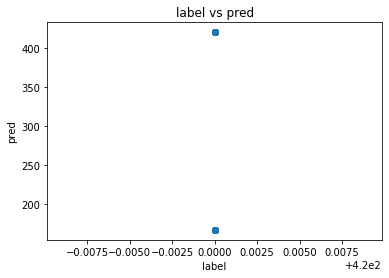

In [21]:
    test_loader = loader = DataLoader([pyData], batch_size=1)

    # build model
    model = GNNStack(max(pyData.num_node_features, 1), 32)
    opt = optim.Adam(model.parameters(), lr=0.25)
    
    # train
    for epoch in range(800):
        total_loss = 0
        model.train()
        for batch in loader:
            #print(batch.train_mask, '----')
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        #writer.add_scalar("loss", total_loss, epoch)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            #writer.add_scalar("test accuracy", test_acc, epoch)
    for data in test_loader:
        pred = model(data).detach().numpy()
        label = data.y.detach().numpy()
        #plt.plot(range(len(label)),label)
        #plt.plot(range(len(label)),pred)
        plt.scatter(label,pred)
        plt.ylabel('pred')
        plt.xlabel('label')
        plt.title('label vs pred')
        plt.show()
        break
    #return model


In [ ]:
    for data in test_loader:
        pred = model(data).detach().numpy()
        label = data.y.detach().numpy()
        plt.plot(range(len(label)),label)
        plt.plot(range(len(pred)),pred)
        #plt.scatter(label,pred)
        plt.ylabel('pred')
        plt.xlabel('label')
        plt.title('label vs pred')
        plt.show()
        #print(pred)
        #for i in range(len(pred)):
        #    print(label[i],pred[i])
        #print(label)
        break

In [16]:
for d in test_loader:
    print(d.y.detach().numpy())
    break

[[420.]
 [420.]
 [420.]
 ...
 [420.]
 [420.]
 [420.]]
